In [4]:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [79]:
def get_cohorts(df, step=step, func=None, cumulative=False):
    results = []
    max_nb_ratings = df['nb_train_ratings'].max()
    start, end = 0, step
    while end < max_nb_ratings:
        mask = (df['nb_train_ratings'] >= start) & (df['nb_train_ratings'] < end)
        df_cohort = df.loc[mask]
        cohort_result = func(df_cohort) if func else df_cohort
        results.append(cohort_result)
        if not cumulative:
            start += step
        end += step
    return results

def get_user_cohorts(df_train, step=step, cumulative=False):
    df_train = df_train.groupby('user_id')['rating'].count().reset_index()
    df_train = df_train.rename(columns={'rating': 'nb_train_ratings'})
    return get_cohorts(df_train, step=step, cumulative=cumulative)

def get_movie_cohorts(df_train, step=step, cumulative=False):
    df_train = df_train.groupby('movie_id')['rating'].count().reset_index()
    df_train = df_train.rename(columns={'rating': 'nb_train_ratings'})
    return get_cohorts(df_train, step=step, cumulative=cumulative)

def plot_user_cohort_distribution(df_train, step=step):
    print "Cohort 0: users who have 0-5 training ratings"
    print "Cohort 1: users who have 5-10 training ratings"
    
    user_cohorts = get_user_cohorts(df_train, step=step)
    nb_users_per_cohort = map(lambda df: len(df), user_cohorts)
    fig = plt.figure(figsize=(15,10))
    ax = plt.gca()
    ax.set_ylabel('number of users')
    ax.set_xlabel('cohort (users)')
    ax.plot(xrange(len(nb_users_per_cohort)),nb_users_per_cohort, 'b')
    
    cumulative_users = np.cumsum(nb_users_per_cohort, dtype=np.float)
    cumulative_users /= cumulative_users[-1]
    fig = plt.figure(figsize=(15,10))
    ax = plt.gca()
    ax.set_ylabel('percent of users')
    ax.set_xlabel('users that have x or less training ratings')
    x_axis = [(i+1) * step for i in xrange(len(cumulative_users))]
    ax.plot(x_axis,cumulative_users, 'b')
    
def plot_movie_cohort_distribution(df_train, step=step):
    print "Cohort 0: movies who have 0-5 training ratings"
    print "Cohort 1: movies who have 5-10 training ratings"
    
    movie_cohorts = get_movie_cohorts(df_train, step=step)
    nb_movies_per_cohort = map(lambda df: len(df), movie_cohorts)
    fig = plt.figure(figsize=(15,10))
    ax = plt.gca()
    ax.set_ylabel('number of movies')
    ax.set_xlabel('cohort (movie)')
    ax.plot(xrange(len(nb_movies_per_cohort)),nb_movies_per_cohort, 'b')
    
    cumulative_movies = np.cumsum(nb_movies_per_cohort, dtype=np.float)
    cumulative_movies /= cumulative_movies[-1]
    fig = plt.figure(figsize=(15,10))
    ax = plt.gca()
    ax.set_ylabel('percent of movies')
    ax.set_xlabel('movies that have x or less training ratings')
    x_axis = [(i+1) * step for i in xrange(len(cumulative_movies))]
    ax.plot(x_axis,cumulative_movies, 'b')

def plot_metric(model_metrics, metric_name, step=step, cumulative=False, mlabel='', xlabel='', ylabel='', nb_cohorts=None, fig=None, color='r', loc='upper right'):
    func = lambda df: df[metric_name].mean()
    
    model_metric_per_cohort = get_cohorts(model_metrics, step=step, func=func, cumulative=cumulative)
    
    if nb_cohorts:
        model_metric_per_cohort = model_metric_per_cohort[:nb_cohorts]
    
    if not fig:
        fig = plt.figure(figsize=(8,6))
    ax = fig.gca()
    
    if len(ylabel) > 0:
        ax.set_ylabel(ylabel, size=15)

    if len(xlabel) > 0:
            ax.set_xlabel(xlabel, size=15)
    
    if cumulative:
        x_axis = [(i) * step for i in xrange(len(model_metric_per_cohort))]
    else:
        x_axis = [i for i in xrange(len(model_metric_per_cohort))]
    #assert len(model1_metric_per_cohort) == len(model2_metric_per_cohort)

    ax.plot(x_axis, model_metric_per_cohort, color, label=mlabel)
    ax.legend(loc=loc)
    
    print "avg {} for {} model:\t".format(metric_name, mlabel), model_metrics[metric_name].mean()
    
    return fig

## ML-100k

In [95]:
mpcf_si_metrics = pd.read_csv('../metrics/mpcf-si/2016-06-27_08.23.04_si_ml-100k_e20_tt-0.7_task-1_user-metrics.csv')
mpcf_metrics = pd.read_csv('../metrics/mpcf/2016-06-20_18.30.50_no-si_ml-100k_e20_tt-0.7_base_user-metrics.csv')
mfnn_metrics = pd.read_csv('../metrics/mfnn/2016-06-29_19.46.38_mfnn_ml-100k_e20_tt-0.7_task-5_user-metrics.csv')
bprmf_metrics = pd.read_csv('../metrics/bprmf/2016-05-27_16.15.55_bprmf_ml-100k_e20_tt-0.7_task-20_user-metrics.csv')
slim_metrics = pd.read_csv('../metrics/slim/2016-05-31_15.17.43_slim_ml-100k_e5_tt-0.7_task-16_user-metrics.csv')

mpcf_si_metrics.head(1)

,auc,avg_precision,f1,fcp,nb_movies_not_in_train,nb_test_ratings,nb_train_ratings,precision_at_20,rankings,recall_at_20,reciprocal_rank,spearman_rank_corr,user_id
0,0.904457,0.131132,0.125,0.658009,1199,22,62,0.1,"[[0, 9, 13, 25, 27, 28, 29, 31, 33, 35, 49, 51...",0.166667,0.1,0.128034,186


avg auc for MPCFs-SI model:	0.937411280163
avg auc for MPCFs model:	0.935918221087
avg auc for MFNN model:	0.935373064615
avg auc for BPRMF model:	0.922877756851
avg auc for SLIM model:	0.914040305355


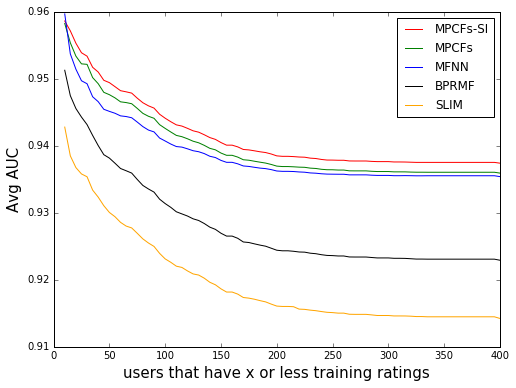

In [99]:
step=5
fig = plot_metric(mpcf_si_metrics, 'auc', step=step,cumulative=True, mlabel='MPCFs-SI', xlabel='users that have x or less training ratings', ylabel='Avg AUC')
fig = plot_metric(mpcf_metrics, 'auc', step=step,cumulative=True, mlabel='MPCFs', fig=fig, color='g')
fig = plot_metric(mfnn_metrics, 'auc', step=step,cumulative=True, mlabel='MFNN', fig=fig, color='b')
fig = plot_metric(bprmf_metrics, 'auc', step=step,cumulative=True, mlabel='BPRMF', fig=fig, color='black')
fig = plot_metric(slim_metrics, 'auc', step=step,cumulative=True, mlabel='SLIM', fig=fig, color='orange')

avg spearman_rank_corr for MPCFs-SI model:	0.200228882497
avg spearman_rank_corr for MPCFs model:	0.201399579078
avg spearman_rank_corr for MFNN model:	0.191577705671
avg spearman_rank_corr for BPRMF model:	0.167194864963
avg spearman_rank_corr for SLIM model:	0.192208902079


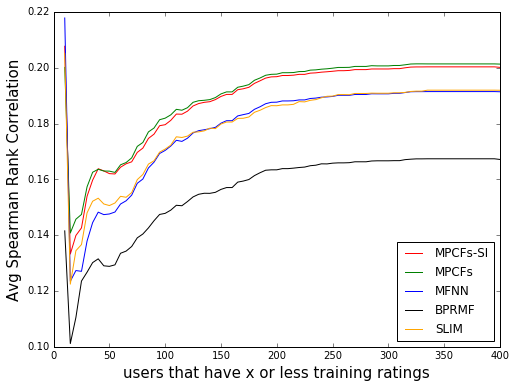

In [88]:
step=5
loc='lower right'
cum=True
fig = plot_metric(mpcf_si_metrics, 'spearman_rank_corr', step=step,cumulative=cum,
                  mlabel='MPCFs-SI',
                  xlabel='users that have x or less training ratings',
                  ylabel='Avg Spearman Rank Correlation', loc=loc)
fig = plot_metric(mpcf_metrics, 'spearman_rank_corr', step=step,cumulative=cum, mlabel='MPCFs', fig=fig, color='g',loc=loc)
fig = plot_metric(mfnn_metrics, 'spearman_rank_corr', step=step,cumulative=cum, mlabel='MFNN', fig=fig, color='b',loc=loc)
fig = plot_metric(bprmf_metrics, 'spearman_rank_corr', step=step,cumulative=cum, mlabel='BPRMF', fig=fig, color='black',loc=loc)
fig = plot_metric(slim_metrics, 'spearman_rank_corr', step=step,cumulative=cum, mlabel='SLIM', fig=fig, color='orange',loc=loc)

avg precision_at_20 for MPCFs-SI model:	0.278791092259
avg precision_at_20 for MPCFs model:	0.275503711559
avg precision_at_20 for MFNN model:	0.285683987275
avg precision_at_20 for BPRMF model:	0.18361611877
avg precision_at_20 for SLIM model:	0.233191940615


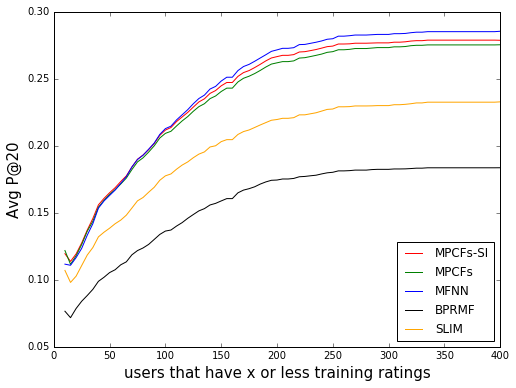

In [89]:
step=5
loc='lower right'
cum=True
fig = plot_metric(mpcf_si_metrics, 'precision_at_20', step=step,cumulative=cum,
                  mlabel='MPCFs-SI', 
                  xlabel='users that have x or less training ratings',
                  ylabel='Avg P@20', loc=loc)
fig = plot_metric(mpcf_metrics, 'precision_at_20', step=step,cumulative=cum, mlabel='MPCFs', fig=fig, color='g', loc=loc)
fig = plot_metric(mfnn_metrics, 'precision_at_20', step=step,cumulative=cum, mlabel='MFNN', fig=fig, color='b', loc=loc)
fig = plot_metric(bprmf_metrics, 'precision_at_20', step=step,cumulative=cum, mlabel='BPRMF', fig=fig, color='black', loc=loc)
fig = plot_metric(slim_metrics, 'precision_at_20', step=step,cumulative=cum, mlabel='SLIM', fig=fig, color='orange', loc=loc)

avg recall_at_20 for MPCFs-SI model:	0.440227257055
avg recall_at_20 for MPCFs model:	0.43473607765
avg recall_at_20 for MFNN model:	0.441398927744
avg recall_at_20 for BPRMF model:	0.287104708214
avg recall_at_20 for SLIM model:	0.375544467851


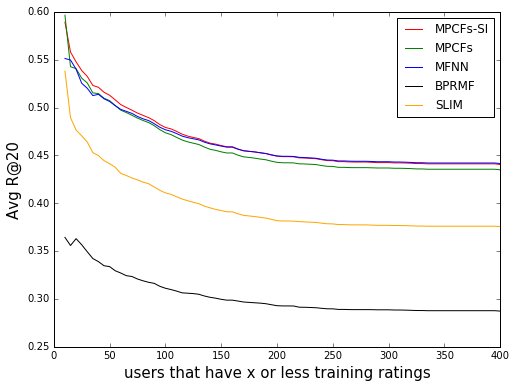

In [90]:
step=5
fig = plot_metric(mpcf_si_metrics, 'recall_at_20', step=step,cumulative=True,
                  mlabel='MPCFs-SI', 
                  xlabel='users that have x or less training ratings',
                  ylabel='Avg R@20')
fig = plot_metric(mpcf_metrics, 'recall_at_20', step=step,cumulative=True, mlabel='MPCFs', fig=fig, color='g')
fig = plot_metric(mfnn_metrics, 'recall_at_20', step=step,cumulative=True, mlabel='MFNN', fig=fig, color='b')
fig = plot_metric(bprmf_metrics, 'recall_at_20', step=step,cumulative=True, mlabel='BPRMF', fig=fig, color='black')
fig = plot_metric(slim_metrics, 'recall_at_20', step=step,cumulative=True, mlabel='SLIM', fig=fig, color='orange')

avg reciprocal_rank for MPCFs-SI model:	0.669648083029
avg reciprocal_rank for MPCFs model:	0.660980143398
avg reciprocal_rank for MFNN model:	0.661673216443
avg reciprocal_rank for BPRMF model:	0.370202959068
avg reciprocal_rank for SLIM model:	0.591271706783


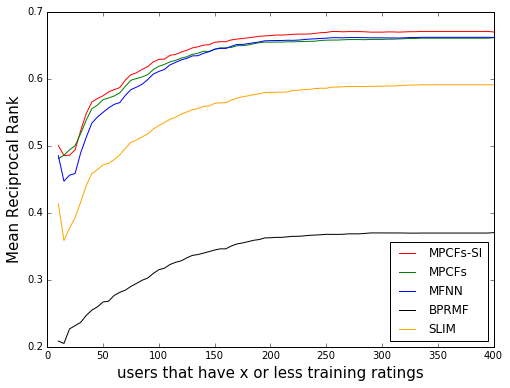

In [91]:
step=5
loc='lower right'
cum=True
fig = plot_metric(mpcf_si_metrics, 'reciprocal_rank', step=step,cumulative=cum, 
                  mlabel='MPCFs-SI', 
                  xlabel='users that have x or less training ratings',
                  ylabel='Mean Reciprocal Rank', loc=loc)
fig = plot_metric(mpcf_metrics, 'reciprocal_rank', step=step,cumulative=cum, mlabel='MPCFs', fig=fig, color='g', loc=loc)
fig = plot_metric(mfnn_metrics, 'reciprocal_rank', step=step,cumulative=cum, mlabel='MFNN', fig=fig, color='b', loc=loc)
fig = plot_metric(bprmf_metrics, 'reciprocal_rank', step=step,cumulative=cum, mlabel='BPRMF', fig=fig, color='black', loc=loc)
fig = plot_metric(slim_metrics, 'reciprocal_rank', step=step,cumulative=cum, mlabel='SLIM', fig=fig, color='orange', loc=loc)

avg fcp for MPCFs-SI model:	0.718397554258
avg fcp for MPCFs model:	0.718449208562
avg fcp for MFNN model:	0.715759736469
avg fcp for BPRMF model:	0.707425830273
avg fcp for SLIM model:	0.716026279715


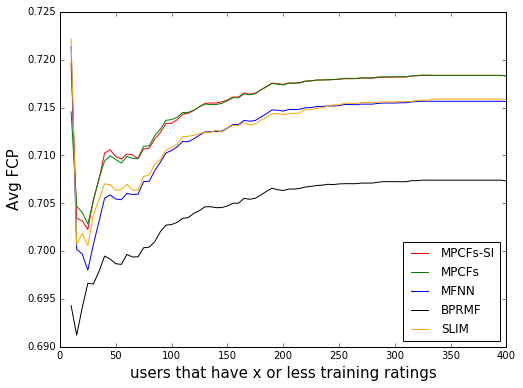

In [92]:
step=5
loc='lower right'
cum=True
fig = plot_metric(mpcf_si_metrics, 'fcp', step=step,cumulative=cum,
                  mlabel='MPCFs-SI',
                  xlabel='users that have x or less training ratings',
                  ylabel='Avg FCP',loc=loc)
fig = plot_metric(mpcf_metrics, 'fcp', step=step,cumulative=cum, mlabel='MPCFs', fig=fig, color='g',loc=loc)
fig = plot_metric(mfnn_metrics, 'fcp', step=step,cumulative=cum, mlabel='MFNN', fig=fig, color='b',loc=loc)
fig = plot_metric(bprmf_metrics, 'fcp', step=step,cumulative=cum, mlabel='BPRMF', fig=fig, color='black',loc=loc)
fig = plot_metric(slim_metrics, 'fcp', step=step,cumulative=cum, mlabel='SLIM', fig=fig, color='orange',loc=loc)

avg auc for MPCFs-SI model:	0.873320369661
avg auc for MPCFs model:	0.87200724315
avg auc for MFNN model:	0.862551376077
avg auc for BPRMF model:	0.653715005117
avg auc for SLIM model:	0.818958019365


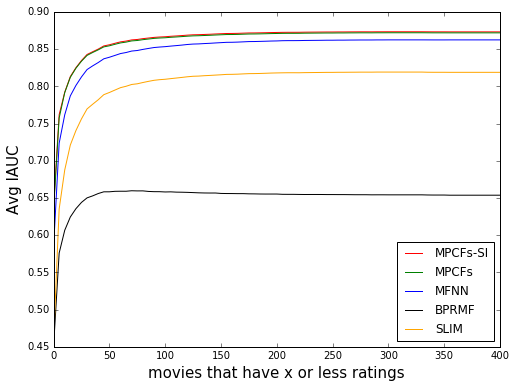

In [100]:
mpcf_si_metrics = pd.read_csv('../metrics/mpcf-si/2016-06-27_08.23.04_si_ml-100k_e20_tt-0.7_task-1_movie-metrics.csv')
mpcf_metrics = pd.read_csv('../metrics/mpcf/2016-06-20_18.30.50_no-si_ml-100k_e20_tt-0.7_base_movie-metrics.csv')
mfnn_metrics = pd.read_csv('../metrics/mfnn/2016-06-29_19.46.38_mfnn_ml-100k_e20_tt-0.7_task-5_movie-metrics.csv')
bprmf_metrics = pd.read_csv('../metrics/bprmf/2016-05-27_16.15.55_bprmf_ml-100k_e20_tt-0.7_task-20_movie-metrics.csv')
slim_metrics = pd.read_csv('../metrics/slim/2016-05-31_15.17.43_slim_ml-100k_e5_tt-0.7_task-16_movie-metrics.csv')

step=5
loc='lower right'
fig = plot_metric(mpcf_si_metrics, 'auc', step=step,cumulative=True,
                  mlabel='MPCFs-SI', 
                  xlabel='movies that have x or less ratings', 
                  ylabel='Avg IAUC', loc=loc)
fig = plot_metric(mpcf_metrics, 'auc', step=step,cumulative=True, mlabel='MPCFs', fig=fig, color='g', loc=loc)
fig = plot_metric(mfnn_metrics, 'auc', step=step,cumulative=True, mlabel='MFNN', fig=fig, color='b', loc=loc)
fig = plot_metric(bprmf_metrics, 'auc', step=step,cumulative=True, mlabel='BPRMF', fig=fig, color='black', loc=loc)
fig = plot_metric(slim_metrics, 'auc', step=step,cumulative=True, mlabel='SLIM', fig=fig, color='orange', loc=loc)

## ML-1M

In [117]:
mpcf_si_metrics = pd.read_csv('../metrics/mpcf-si/2016-06-29_13.23.36_si_ml-1m_e20_tt-0.7_task-0_user-metrics.csv')
mpcf_metrics = pd.read_csv('../metrics/mpcf/2016-05-27_20.57.43_no-si_ml-1m_e20_tt-0.7_task-22_user-metrics.csv')
mfnn_metrics = pd.read_csv('../metrics/mfnn/2016-06-25_22.58.04_mfnn_ml-1m_e10_tt-0.7_task-0_user-metrics.csv')
bprmf_metrics = pd.read_csv('../metrics/bprmf/2016-05-24_18.04.12_bprmf_ml-1m_e20_tt-0.7_task-19_user-metrics.csv')
slim_metrics = pd.read_csv('../metrics/slim/2016-05-31_15.25.26_slim_ml-1m_e5_tt-0.7_task-10_user-metrics.csv')

mpcf_si_metrics.head(1)

,auc,avg_precision,f1,fcp,nb_movies_not_in_train,nb_test_ratings,nb_train_ratings,precision_at_20,rankings,recall_at_20,reciprocal_rank,spearman_rank_corr,user_id
0,0.937894,0.224858,0.2,0.711111,2963,10,42,0.15,"[[1, 2, 7, 21, 23, 55, 57, 149, 326, 1238]]",0.3,0.5,-0.189934,1


avg auc for MPCFs-SI model:	0.92898763495
avg auc for MPCFs model:	0.928741575437
avg auc for MFNN model:	0.930206840644
avg auc for BPRMF model:	0.918559898867
avg auc for SLIM model:	0.912640221165


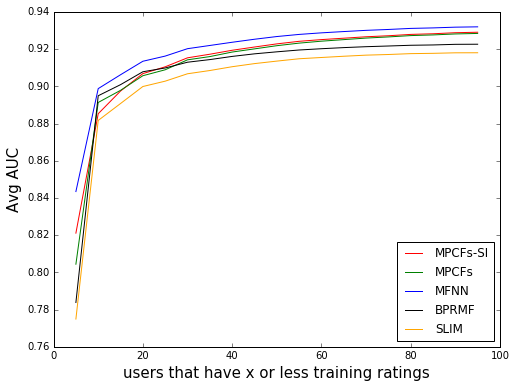

In [118]:
step=5
loc='lower right'
nb_cohorts=20
fig = plot_metric(mpcf_si_metrics, 'auc', step=step,cumulative=True,
                  mlabel='MPCFs-SI', 
                  xlabel='users that have x or less training ratings', 
                  ylabel='Avg AUC', loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(mpcf_metrics, 'auc', step=step,cumulative=True, mlabel='MPCFs', fig=fig, color='g', loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(mfnn_metrics, 'auc', step=step,cumulative=True, mlabel='MFNN', fig=fig, color='b', loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(bprmf_metrics, 'auc', step=step,cumulative=True, mlabel='BPRMF', fig=fig, color='black', loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(slim_metrics, 'auc', step=step,cumulative=True, mlabel='SLIM', fig=fig, color='orange', loc=loc, nb_cohorts=nb_cohorts)

avg spearman_rank_corr for MPCFs-SI model:	0.225229575847
avg spearman_rank_corr for MPCFs model:	0.223963893665
avg spearman_rank_corr for MFNN model:	0.23469097261
avg spearman_rank_corr for BPRMF model:	0.202924798819
avg spearman_rank_corr for SLIM model:	0.233961159018


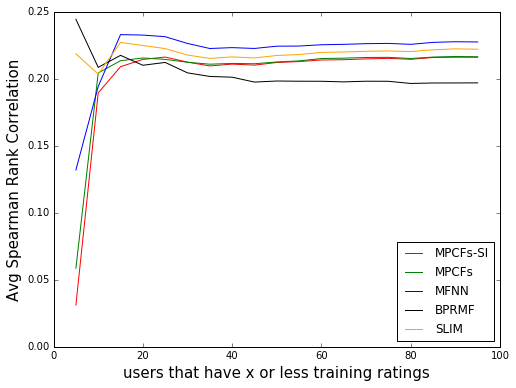

In [119]:
step=5
loc='lower right'
cum=True
nb_cohorts=20
fig = plot_metric(mpcf_si_metrics, 'spearman_rank_corr', step=step,cumulative=cum,
                  mlabel='MPCFs-SI',
                  xlabel='users that have x or less training ratings',
                  ylabel='Avg Spearman Rank Correlation', loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(mpcf_metrics, 'spearman_rank_corr', step=step,cumulative=cum, mlabel='MPCFs', fig=fig, color='g',loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(mfnn_metrics, 'spearman_rank_corr', step=step,cumulative=cum, mlabel='MFNN', fig=fig, color='b',loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(bprmf_metrics, 'spearman_rank_corr', step=step,cumulative=cum, mlabel='BPRMF', fig=fig, color='black',loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(slim_metrics, 'spearman_rank_corr', step=step,cumulative=cum, mlabel='SLIM', fig=fig, color='orange',loc=loc, nb_cohorts=nb_cohorts)

avg precision_at_20 for MPCFs-SI model:	0.320968543046
avg precision_at_20 for MPCFs model:	0.327698675497
avg precision_at_20 for MFNN model:	0.305745033113
avg precision_at_20 for BPRMF model:	0.213907284768
avg precision_at_20 for SLIM model:	0.286266556291


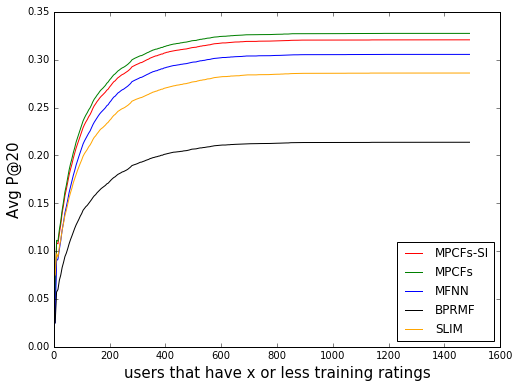

In [120]:
step=5
loc='lower right'
cum=True
nb_cohorts=None
fig = plot_metric(mpcf_si_metrics, 'precision_at_20', step=step,cumulative=cum,
                  mlabel='MPCFs-SI', 
                  xlabel='users that have x or less training ratings',
                  ylabel='Avg P@20', loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(mpcf_metrics, 'precision_at_20', step=step,cumulative=cum, mlabel='MPCFs', fig=fig, color='g', loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(mfnn_metrics, 'precision_at_20', step=step,cumulative=cum, mlabel='MFNN', fig=fig, color='b', loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(bprmf_metrics, 'precision_at_20', step=step,cumulative=cum, mlabel='BPRMF', fig=fig, color='black', loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(slim_metrics, 'precision_at_20', step=step,cumulative=cum, mlabel='SLIM', fig=fig, color='orange', loc=loc, nb_cohorts=nb_cohorts)

avg recall_at_20 for MPCFs-SI model:	0.328111042355
avg recall_at_20 for MPCFs model:	0.336678538493
avg recall_at_20 for MFNN model:	0.301778627403
avg recall_at_20 for BPRMF model:	0.202200468385
avg recall_at_20 for SLIM model:	0.289716787815


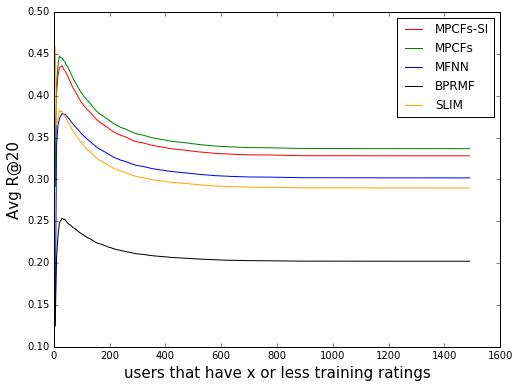

In [121]:
step=5
nb_cohorts=None
fig = plot_metric(mpcf_si_metrics, 'recall_at_20', step=step,cumulative=True,
                  mlabel='MPCFs-SI', 
                  xlabel='users that have x or less training ratings',
                  ylabel='Avg R@20', nb_cohorts=nb_cohorts)
fig = plot_metric(mpcf_metrics, 'recall_at_20', step=step,cumulative=True, mlabel='MPCFs', fig=fig, color='g', nb_cohorts=nb_cohorts)
fig = plot_metric(mfnn_metrics, 'recall_at_20', step=step,cumulative=True, mlabel='MFNN', fig=fig, color='b', nb_cohorts=nb_cohorts)
fig = plot_metric(bprmf_metrics, 'recall_at_20', step=step,cumulative=True, mlabel='BPRMF', fig=fig, color='black', nb_cohorts=nb_cohorts)
fig = plot_metric(slim_metrics, 'recall_at_20', step=step,cumulative=True, mlabel='SLIM', fig=fig, color='orange', nb_cohorts=nb_cohorts)

avg reciprocal_rank for MPCFs-SI model:	0.69664549889
avg reciprocal_rank for MPCFs model:	0.702876167091
avg reciprocal_rank for MFNN model:	0.652707494288
avg reciprocal_rank for BPRMF model:	0.443406619371
avg reciprocal_rank for SLIM model:	0.647692899265


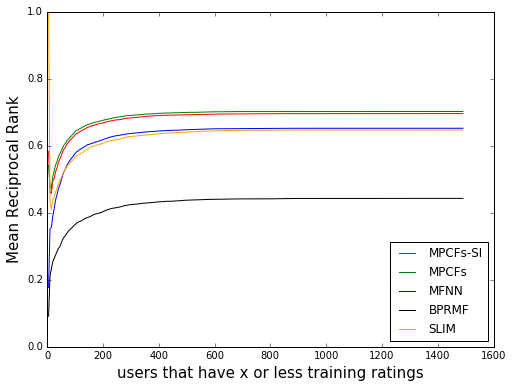

In [122]:
step=5
loc='lower right'
cum=True
nb_cohorts=None
fig = plot_metric(mpcf_si_metrics, 'reciprocal_rank', step=step,cumulative=cum, 
                  mlabel='MPCFs-SI', 
                  xlabel='users that have x or less training ratings',
                  ylabel='Mean Reciprocal Rank', loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(mpcf_metrics, 'reciprocal_rank', step=step,cumulative=cum, mlabel='MPCFs', fig=fig, color='g', loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(mfnn_metrics, 'reciprocal_rank', step=step,cumulative=cum, mlabel='MFNN', fig=fig, color='b', loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(bprmf_metrics, 'reciprocal_rank', step=step,cumulative=cum, mlabel='BPRMF', fig=fig, color='black', loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(slim_metrics, 'reciprocal_rank', step=step,cumulative=cum, mlabel='SLIM', fig=fig, color='orange', loc=loc, nb_cohorts=nb_cohorts)

avg fcp for MPCFs-SI model:	0.728433912842
avg fcp for MPCFs model:	0.728025908602
avg fcp for MFNN model:	0.731660425202
avg fcp for BPRMF model:	0.720853237428
avg fcp for SLIM model:	0.731257885308


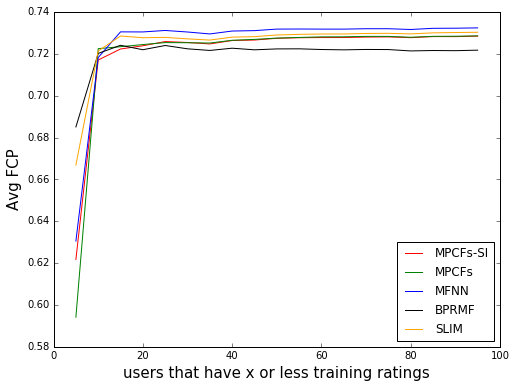

In [123]:
step=5
loc='lower right'
cum=True
nb_cohorts=20
fig = plot_metric(mpcf_si_metrics, 'fcp', step=step,cumulative=cum,
                  mlabel='MPCFs-SI',
                  xlabel='users that have x or less training ratings',
                  ylabel='Avg FCP',loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(mpcf_metrics, 'fcp', step=step,cumulative=cum, mlabel='MPCFs', fig=fig, color='g',loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(mfnn_metrics, 'fcp', step=step,cumulative=cum, mlabel='MFNN', fig=fig, color='b',loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(bprmf_metrics, 'fcp', step=step,cumulative=cum, mlabel='BPRMF', fig=fig, color='black',loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(slim_metrics, 'fcp', step=step,cumulative=cum, mlabel='SLIM', fig=fig, color='orange',loc=loc, nb_cohorts=nb_cohorts)

avg auc for MPCFs-SI model:	0.873320369661
avg auc for MPCFs model:	0.87200724315
avg auc for MFNN model:	0.862551376077
avg auc for BPRMF model:	0.653715005117
avg auc for SLIM model:	0.818958019365


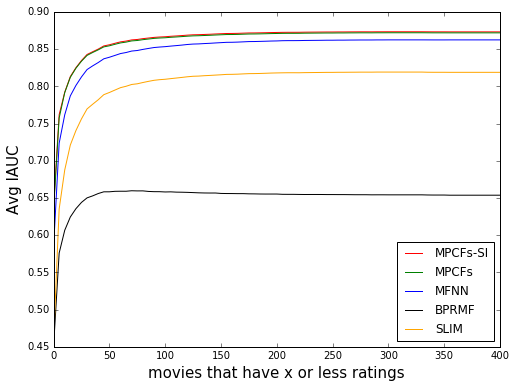

In [115]:
mpcf_si_metrics = pd.read_csv('../metrics/mpcf-si/2016-06-27_08.23.04_si_ml-100k_e20_tt-0.7_task-1_movie-metrics.csv')
mpcf_metrics = pd.read_csv('../metrics/mpcf/2016-06-20_18.30.50_no-si_ml-100k_e20_tt-0.7_base_movie-metrics.csv')
mfnn_metrics = pd.read_csv('../metrics/mfnn/2016-06-29_19.46.38_mfnn_ml-100k_e20_tt-0.7_task-5_movie-metrics.csv')
bprmf_metrics = pd.read_csv('../metrics/bprmf/2016-05-27_16.15.55_bprmf_ml-100k_e20_tt-0.7_task-20_movie-metrics.csv')
slim_metrics = pd.read_csv('../metrics/slim/2016-05-31_15.17.43_slim_ml-100k_e5_tt-0.7_task-16_movie-metrics.csv')

step=5
loc='lower right'
nb_cohorts=None
fig = plot_metric(mpcf_si_metrics, 'auc', step=step,cumulative=True,
                  mlabel='MPCFs-SI', 
                  xlabel='movies that have x or less ratings', 
                  ylabel='Avg IAUC', loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(mpcf_metrics, 'auc', step=step,cumulative=True, mlabel='MPCFs', fig=fig, color='g', loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(mfnn_metrics, 'auc', step=step,cumulative=True, mlabel='MFNN', fig=fig, color='b', loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(bprmf_metrics, 'auc', step=step,cumulative=True, mlabel='BPRMF', fig=fig, color='black', loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(slim_metrics, 'auc', step=step,cumulative=True, mlabel='SLIM', fig=fig, color='orange', loc=loc, nb_cohorts=nb_cohorts)

Cohort 0: users who have 0-5 training ratings
Cohort 1: users who have 5-10 training ratings
Cohort 0: movies who have 0-5 training ratings
Cohort 1: movies who have 5-10 training ratings


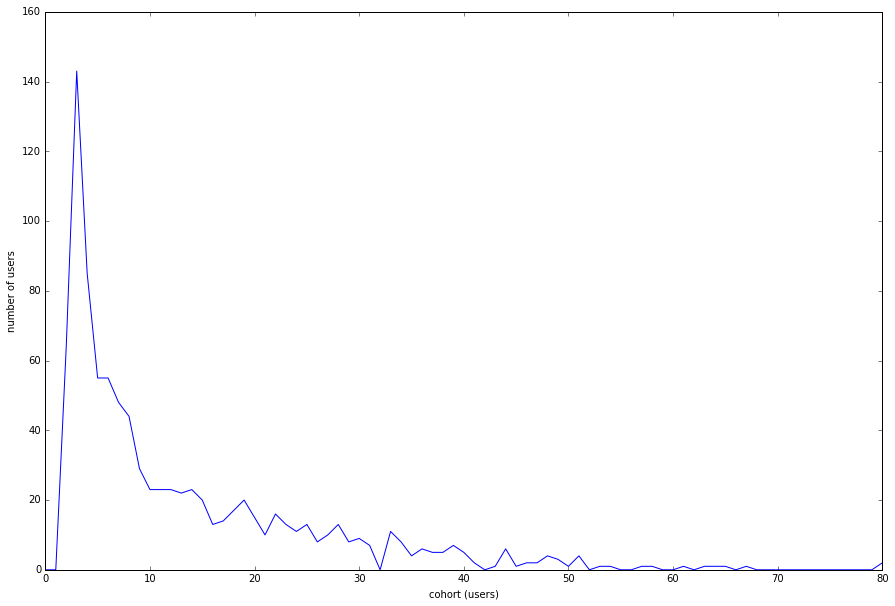

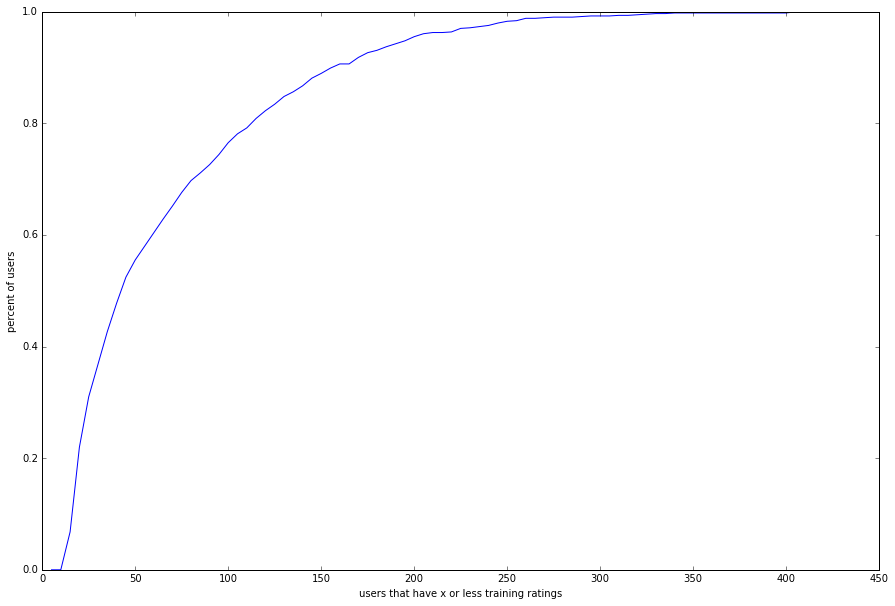

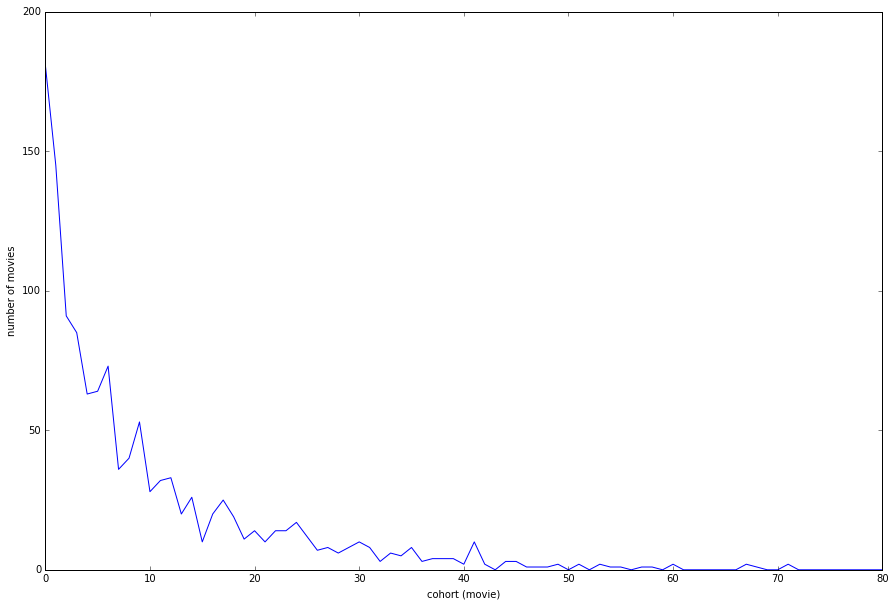

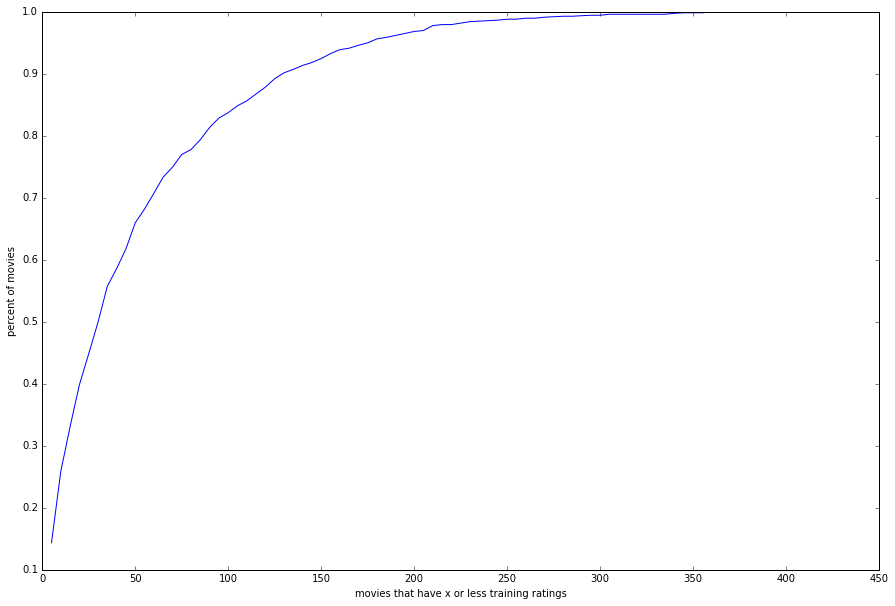

In [38]:
train = pd.read_csv('../data/splits/ml-100k/sparse-item/0.7-train-1.csv')
plot_user_cohort_distribution(train)
plot_movie_cohort_distribution(train)